### How to ensemble clustering algorithms?

> - Since this competition is about clustering 
> - And since it is necessary to ensemble in order to achieve maximum Kaggling. 

On this notebook we show how to ensemble multiple clustering algorithms.

![](https://i.ibb.co/Sy5xgnQ/Scheme-of-ensemble-clustering-approach.png)

[[source](https://www.researchgate.net/figure/Scheme-of-ensemble-clustering-approach_fig1_277589770)]


The approach is simple: We create a sparse matrix of all pairs of samples and assign 1 to any pair of samples that are on the same cluster.

We then simply take the mean/median of all sparse matrices, apply a threshold, and convert it back to cluster ids.

This way we can use multiple clustering algorithms at the same time. 


_____

##### Updated version

Multiple upgrades and fixes had been proposed by [ehekatlact](https://www.kaggle.com/ehekatlact/) on the [this](https://www.kaggle.com/code/ehekatlact/tps2207-ultra-fast-ensemble/data) excellent notebook. 
This notebook had been upgraded with the proposed fixes, it is now extremely fast to run and it also submit to the LB. 

At the bottom of this notebook you can find a single function that performs the full computation end-to-end. 
Copy it wherever you want to perform easy clustering ensemble! 

Have fun! 

In [1]:
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

df = pd.read_csv('../input/tabular-playground-series-jul-2022/data.csv')
df = df.drop(columns = 'id')

#### Now let's say we got two algorithms we want to ensemble

- KMeans(n_clusters = 7)
- Gaussian Mixture(n_components = 7)

In [2]:
clusters_k_means = KMeans(n_clusters = 7).fit_predict(df)
clusters_mixture = GaussianMixture(n_components = 7).fit_predict(df)

print(clusters_k_means.shape)
print(clusters_mixture.shape)

clusters_list = [clusters_k_means, clusters_mixture]

(98000,)
(98000,)


In [3]:
cls_tup_list = []
for cls_tup in zip(*clusters_list):
    cls_tup_list.append(cls_tup)
zipper = {x: i for i, x in enumerate(sorted(set(cls_tup_list)))}
zipped_list = [zipper[x] for x in cls_tup_list]
unzipper = defaultdict(set)
for idx, cls_tup in enumerate(cls_tup_list):
    zipped = zipper[cls_tup]
    unzipper[zipped].add(idx)
comp_clusters_list = [[-1]*len(zipper) for _ in range(len(clusters_list))]
for clusters, comp_clusters in zip(clusters_list, comp_clusters_list):
    for i, cluster_i in enumerate(clusters):
            value = zipped_list[i]
            comp_clusters[value] = cluster_i

### We create a sparse matrix of all pairs of samples and assign 1 to any pair of samples that are on the same cluster.

In [4]:
def create_sparse_matrix(clusters):
    n = len(clusters)
    data = []
    row = []
    col = []
    # O(n**2)
    for i in trange(n):
        for j in range(i+1, n):
            if clusters[i] == clusters[j]:
                data.append(1)
                row.append(i)
                col.append(j)
    return csr_matrix((data, (row, col)), shape=(n, n))

sparse_matrix_list = [create_sparse_matrix(comp_clusters) for comp_clusters in comp_clusters_list]

100%|██████████| 44/44 [00:00<00:00, 72657.23it/s]


### We then simply take the mean/median of all sparse matrices, apply a threshold, and convert it back to cluster ids.

![](https://i.ibb.co/84nnT31/1-s2-0-S153204641300021-X-gr1.jpg)
[[source](https://www.sciencedirect.com/science/article/pii/S153204641300021X)]


In [5]:
sparse_matrix_mean = (sparse_matrix_list[0] * 0.5 + sparse_matrix_list[1] * 0.5)

### Now we apply the threshold

> Special thanks to [ehekatlact](https://www.kaggle.com/ehekatlact) for coming up with this [fix](https://www.kaggle.com/code/ehekatlact/tps2207-ultra-fast-ensemble)! 

Use DSU to control the upper limit of each cluster size to prevent clusters from sticking together.
If you are interested in this phenomenon, try setting SIZ_MAX to float('inf') and experiment with it!

In [6]:
# The lower the threshold the lower number of clusters: Since we are counting by the connected component.
# It seems desirable to set it a little higher.
threshold = 0.5
sparse_matrix_mean[sparse_matrix_mean < threshold] = 0

/opt/conda/lib/python3.7/site-packages/scipy/sparse/compressed.py:291: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Now we reconstruct our clusters and return an integer column

In [7]:
sparse_matrix_mean = sparse_matrix_mean.toarray()
sparse_matrix_mean

array([[0. , 0.5, 0.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0.5, 0.5],
       [0. , 0. , 0. , ..., 0. , 0. , 0.5],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

**Intuition:** The clusters are combined in order of increasing sparse_matrix_mean[node1][node2].

Disjoint Set Union(DSU) is useful, with complexity of O(α(N)).

Algorithm: Repeat until the size of each cluster reaches SIZ_MAX or the number of clusters reaches CLS_NUM_MIN. This is fast enough: O(log(N)*N).

In [8]:
# Sort sparse_matrix_mean[node1][node2] that are non-zero.
# It is fast enough because the number of edges is small due to preprocessing (zipper).
clusters_final = np.zeros(len(df))
clusters_final_next_id = 0

node_end = len(comp_clusters_list[0])
edge_list = []  # [(w, fr, to), ...]
for fr in range(node_end):
    for to in range(fr, node_end):
        w = sparse_matrix_mean[fr][to]
        if w == 0:
            continue
        edge_list.append((w, fr, to))
edge_list.sort(reverse=True)

In [9]:
SIZ_MAX = 18000
CLS_NUM_MIN = 7

#### Disjoint Set Union(DSU)

In [10]:
class DSU:
    def __init__(self, node_end, unzipper):
        self.par = [i for i in range(node_end)]
        self.siz = [len(unzipper[i]) for i in range(node_end)]
        self.cls_num = node_end  # To use the cls_num variable, we declared this class

    def find(self, x):
        if self.par[x] == x: return x
        self.par[x] = self.find(self.par[x])
        return self.par[x]

    def union(self, x, y):
        x = self.find(x)
        y = self.find(y)
        if x == y:
            return
        if self.siz[x] > self.siz[y]: x, y = y, x
        self.par[x] = y
        self.siz[y] += self.siz[x]
        self.cls_num -= 1

    def get_siz(self, x):
        x = self.find(x)
        return self.siz[x]

dsu = DSU(node_end, unzipper)
for w, fr, to in edge_list:
    if (dsu.get_siz(fr)+dsu.get_siz(to)) > SIZ_MAX: continue
    dsu.union(fr, to)
    if dsu.cls_num <= CLS_NUM_MIN:
        print("number of clusters reaches CLS_NUM_MIN: {}".format(CLS_NUM_MIN), " break.")
        break

clusters_final = [0]*len(clusters_list[0])    
for node in range(node_end):
    cluster_id = dsu.find(node)
    idx_list = unzipper[node]
    for idx in idx_list:
        clusters_final[idx] = cluster_id

number of clusters reaches CLS_NUM_MIN: 7  break.


compress cluster_final to replace it with an integer starting from 0.

In [11]:
zipper = {x: i for i, x in enumerate(sorted(set(clusters_final)))}
clusters_final = [zipper[x] for x in clusters_final]

In [12]:
# https://www.kaggle.com/code/ambrosm/tpsjul22-gaussian-mixture-cluster-analysis
def compare_clusterings(y1, y2, title=''):
    """Show the adjusted rand score and plot the two clusterings in color"""
    ars = adjusted_rand_score(y1, y2)
    n1 = y1.max() + 1
    n2 = y2.max() + 1
    argsort = np.argsort(y1*100 + y2) if n1 >= n2 else np.argsort(y2*100 + y1)
    plt.figure(figsize=(16, 0.5))
    for i in range(6, 11):
        plt.scatter(np.arange(len(y1)), np.full_like(y1, i), c=y1[argsort], s=1, cmap='tab10')
    for i in range(5):
        plt.scatter(np.arange(len(y2)), np.full_like(y2, i), c=y2[argsort], s=1, cmap='tab10')
    plt.gca().axis('off')
    plt.title(f'{title}\nAdjusted Rand score: {ars:.5f}')
    plt.savefig(title + '.png', bbox_inches='tight')
    plt.show()

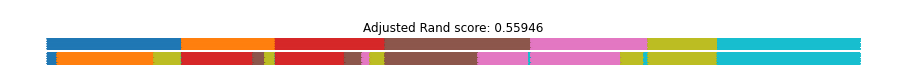

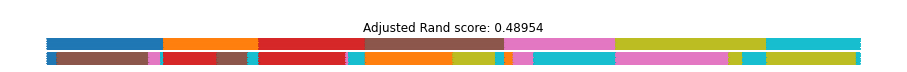

In [13]:
for clusters in clusters_list: compare_clusterings(np.array(clusters), np.array(clusters_final))

In [14]:
submission = pd.read_csv("../input/tabular-playground-series-jul-2022/sample_submission.csv")
submission["Predicted"] = clusters_final
submission.to_csv("submission.csv", index=False)
submission

,Id,Predicted
0,0,6
1,1,3
2,2,6
3,3,5
4,4,4
...,...,...
97995,97995,3
97996,97996,4
97997,97997,1
97998,97998,1


_____

### Single Function
##### Let's make a single functions out of all of this - for ease of use

In [15]:
# Copy this cell wherever you want without thinking 👌

# (I sacrifice readability and devise ways to make memory errors less likely to occur.)
import numpy as np
import pandas as pd
from tqdm import trange
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

def clustering_ensemble(clusters_list, weights = None, threshold = 0.5, size_max = 18000, cls_num_min = 7):
    """
    Parameters: 
                clusters_list:  List of numpy arrays, representing the cluster_id of each data point
                weights:        List representing the voting weight, for example = [0.5, 0.5]. default None (uses uniform weights)
                threshold:      float(0.0, 1.0), the threshold for determining an edge in the sparse matrix, default 0.5
                size_max:       The maximum size of a cluster, default 18000
                cls_num_min:    The minimum number of clusters, default 7
    Returns: 
                clusters_final: An ensemble of the clustering algorithms predictions.
    weights: Where the ensemble results are the same as before the ensemble, when it does not work, tweaking here may work.
    threshold: The larger the larger, the faster; If you don't have enough memory, try making it bigger.
    """
    # zip same cluster.
    cls_tup_list = []
    for cls_tup in zip(*clusters_list):
        cls_tup_list.append(cls_tup)
    zipper = {x: i for i, x in enumerate(sorted(set(cls_tup_list)))}
    zipped_list = [zipper[x] for x in cls_tup_list]
    unzipper = defaultdict(set)
    for idx, cls_tup in enumerate(cls_tup_list):
        zipped = zipper[cls_tup]
        unzipper[zipped].add(idx)
    comp_clusters_list = [[-1]*len(zipper) for _ in range(len(clusters_list))]
    node_end = len(comp_clusters_list[0])
    print(node_end)
    for clusters, comp_clusters in zip(clusters_list, comp_clusters_list):
        for i, cluster_i in enumerate(clusters):
                value = zipped_list[i]
                comp_clusters[value] = cluster_i             
    # calc adjacency matrix(sparse). and calc score(weighted average)
    # memory error. OMG. I created my own simple. I believe that the reduction in space computation by creating the system by oneself is more advantageous than the constant-doubling speed-up by numpy.
    def create_sparse_matrix(clusters):
        sparse = defaultdict(lambda :defaultdict(int))  # High speed by utilizing cache memory. sparse[(node1, node2)] is slow.
        # if clusters[node1] == clusters[node2] then sparse[node1][node2] = 1
        cluster_idx_of = defaultdict(set)  # cls_inx_of[clster] = set(idx)
        for idx, cluster in enumerate(clusters):
            cluster_idx_of[cluster].add(idx)
        for cluster, idx_list in cluster_idx_of.items():
            for node1 in idx_list:
                for node2 in idx_list:
                    sparse[node1][node2] = 1
        return sparse
    sparse_matrix_list = [create_sparse_matrix(comp_clusters) for comp_clusters in tqdm(comp_clusters_list)]
    if weights is None: weights = [1 / len(sparse_matrix_list) for i in range(len(sparse_matrix_list))]
    weights = np.asarray(weights) / np.sum(weights)
    # Define edge_list (val, node1, node2).
    # However, if you do it normally, there is not enough memory because sparse_matrix_mean is not sparse. By processing every node1, the amount of space calculation is greatly reduced.
    edge_list = []  # [(val, node1, node2), ...]
    for node1 in trange(node_end):
        sparse_matrix_mean = defaultdict(int)
        for sparce_matrix, weight in zip(sparse_matrix_list, weights):
            col = sparce_matrix[node1]
            for node2, val in col.items():
                sparse_matrix_mean[node2] += val*weight
            for node2, val in sparse_matrix_mean.items():
                if val < threshold or node1 >= node2:
                    continue
                edge_list.append((val, node1, node2))
    edge_list.sort(reverse=True)
    class DSU:
        def __init__(self, node_end, unzipper):
            self.par = [i for i in range(node_end)]
            self.siz = [len(unzipper[i]) for i in range(node_end)]
            self.cls_num = node_end  # To use the cls_num variable, we declared this class
        def find(self, x):
            if self.par[x] == x: return x
            self.par[x] = self.find(self.par[x])
            return self.par[x]
        def union(self, x, y):
            x = self.find(x)
            y = self.find(y)
            if x == y:
                return
            if self.siz[x] > self.siz[y]: x, y = y, x
            self.par[x] = y
            self.siz[y] += self.siz[x]
            self.cls_num -= 1
        def get_siz(self, x):
            x = self.find(x)
            return self.siz[x]
    dsu = DSU(node_end, unzipper)
    for w, fr, to in edge_list:
        if (dsu.get_siz(fr)+dsu.get_siz(to)) > size_max: continue
        dsu.union(fr, to)
        if dsu.cls_num <= cls_num_min:
            print("number of clusters reaches cls_num_min: {}".format(cls_num_min), " break.")
            break
    # Unzip the zipped array.
    clusters_final = [0]*len(clusters_list[0])    
    for node in range(node_end):
        cluster_id = dsu.find(node)
        idx_list = unzipper[node]
        for idx in idx_list:
            clusters_final[idx] = cluster_id
    # Renumbered for easier viewing.
    zipper = {x: i for i, x in enumerate(sorted(set(clusters_final)))}
    clusters_final = [zipper[x] for x in clusters_final]            
    return clusters_final

# Not relevant for ensembles, but if you want to check the result, copy the following as well
# https://www.kaggle.com/code/ambrosm/tpsjul22-gaussian-mixture-cluster-analysis
def compare_clusterings(y1, y2, title=''):
    """Show the adjusted rand score and plot the two clusterings in color"""
    ars = adjusted_rand_score(y1, y2)
    n1 = y1.max() + 1
    n2 = y2.max() + 1
    argsort = np.argsort(y1*100 + y2) if n1 >= n2 else np.argsort(y2*100 + y1)
    plt.figure(figsize=(16, 0.5))
    for i in range(6, 11):
        plt.scatter(np.arange(len(y1)), np.full_like(y1, i), c=y1[argsort], s=1, cmap='tab10')
    for i in range(5):
        plt.scatter(np.arange(len(y2)), np.full_like(y2, i), c=y2[argsort], s=1, cmap='tab10')
    plt.gca().axis('off')
    plt.title(f'{title}\nAdjusted Rand score: {ars:.5f}')
    plt.savefig(title + '.png', bbox_inches='tight')
    plt.show()

### Simple usage example

72


100%|██████████| 72/72 [00:00<00:00, 10718.74it/s]

number of clusters reaches cls_num_min: 7  break.


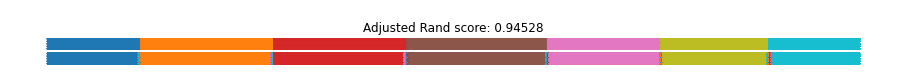

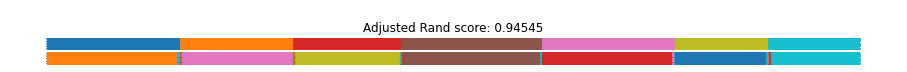

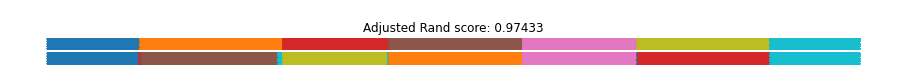

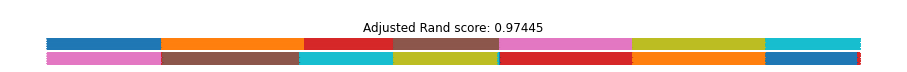

In [16]:
clusters_1 = pd.read_csv("../input/tps-high-scoring-subs/sub_1.csv")["Predicted"]
clusters_2 = pd.read_csv("../input/tps-high-scoring-subs/sub_2.csv")["Predicted"]
clusters_3 = pd.read_csv("../input/tps-high-scoring-subs/sub_3.csv")["Predicted"]
clusters_4 = pd.read_csv("../input/tps-high-scoring-subs/sub_4.csv")["Predicted"]

clusters_list = [clusters_1, clusters_2, clusters_3, clusters_4]

ensemble_preds = clustering_ensemble(clusters_list, weights = None, threshold=0.1)

for clusters in clusters_list: compare_clusterings(np.array(clusters), np.array(ensemble_preds))

### Submission

In [17]:
submission = pd.read_csv("../input/tabular-playground-series-jul-2022/sample_submission.csv")
submission["Predicted"] = ensemble_preds
submission.to_csv("submission.csv", index=False)
submission

,Id,Predicted
0,0,4
1,1,6
2,2,4
3,3,5
4,4,3
...,...,...
97995,97995,6
97996,97996,2
97997,97997,1
97998,97998,0
